Derived Diffusion Coefficient: 0.008457535056646712
Estimated Drift Term: 0.0106365283304965


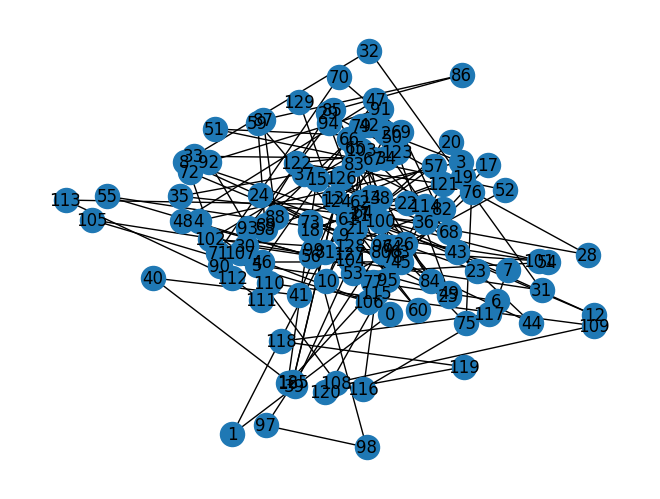

In [1]:
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt

# Step 1: Define the polymer as a graph in NetworkX
def create_polymer_chain(length):
    G = nx.path_graph(length)
    pos = {i: (i, 0) for i in range(length)}
    nx.set_node_attributes(G, pos, 'pos')
    return G

# Step 2: Implement the PIMC method
def path_integral_monte_carlo(G, num_steps, beta):
    positions = np.array([G.nodes[i]['pos'] for i in G.nodes])
    for step in range(num_steps):
        for i in range(len(positions)):
            old_pos = positions[i].copy()
            new_pos = old_pos + np.random.normal(scale=np.sqrt(beta), size=2)
            delta_energy = calculate_energy_change(G, i, old_pos, new_pos)
            if np.random.rand() < np.exp(-beta * delta_energy):
                positions[i] = new_pos
                G.nodes[i]['pos'] = tuple(new_pos)
    return G

def calculate_energy_change(G, node, old_pos, new_pos):
    neighbors = list(G.neighbors(node))
    delta_energy = 0
    for neighbor in neighbors:
        neighbor_pos = np.array(G.nodes[neighbor]['pos'])
        delta_energy += (np.linalg.norm(new_pos - neighbor_pos) - np.linalg.norm(old_pos - neighbor_pos)) ** 2
    return delta_energy

# Step 3: Analyze the results to derive an SDE
def derive_sde(G):
    positions = np.array([G.nodes[i]['pos'] for i in G.nodes])
    displacements = np.diff(positions, axis=0)
    mean_square_displacement = np.mean(np.sum(displacements ** 2, axis=1))
    diffusion_coefficient = mean_square_displacement / (2 * len(G.nodes))
    
    # Compute drift term
    drift_term = compute_drift_term(G)
    
    return diffusion_coefficient, drift_term

def compute_drift_term(G):
    positions = np.array([G.nodes[i]['pos'] for i in G.nodes])
    displacements = np.diff(positions, axis=0)
    
    # Assuming the drift term is the average displacement per unit time
    mean_displacement = np.mean(np.sum(displacements, axis=1), axis=0)
    
    return mean_displacement

# Parameters
length = 130
num_steps = 1000
beta = 0.76

# Create polymer chain
G = create_polymer_chain(length)

# Perform PIMC
G = path_integral_monte_carlo(G, num_steps, beta)

# Derive SDE results
diffusion_coefficient, drift_term = derive_sde(G)
print("Derived Diffusion Coefficient:", diffusion_coefficient)
print("Estimated Drift Term:", drift_term)

# Visualize the final configuration
pos = nx.get_node_attributes(G, 'pos')
nx.draw(G, pos, with_labels=True)
plt.show()

In [2]:
import numpy as np
import matplotlib.pyplot as plt

# Parameters for the SDE simulation
num_simulations = 1000
num_steps = 1000
dt = 0.01
D = diffusion_coefficient  # Diffusion coefficient derived from PIMC
drift_term = drift_term   # Drift term derived from PIMC

# Function to simulate the SDE using the Euler-Maruyama method with drift term
def simulate_sde(D, drift_term, num_simulations, num_steps, dt):
    X = np.zeros((num_simulations, num_steps))
    for i in range(num_simulations):
        for t in range(1, num_steps):
            dW = np.sqrt(dt) * np.random.randn()
            X[i, t] = X[i, t-1] + drift_term * dt + np.sqrt(2 * D) * dW
    return X

# Simulate the SDE
X = simulate_sde(D, drift_term, num_simulations, num_steps, dt)

In [4]:
def rescale_data(X):
    min_val = np.min(X)
    max_val = np.max(X)
    return 2 * (X - min_val) / (max_val - min_val) - 1

Histogram integral at t=1.00: 1.0000
Histogram integral at t=5.00: 1.0000
Histogram integral at t=9.80: 1.0000


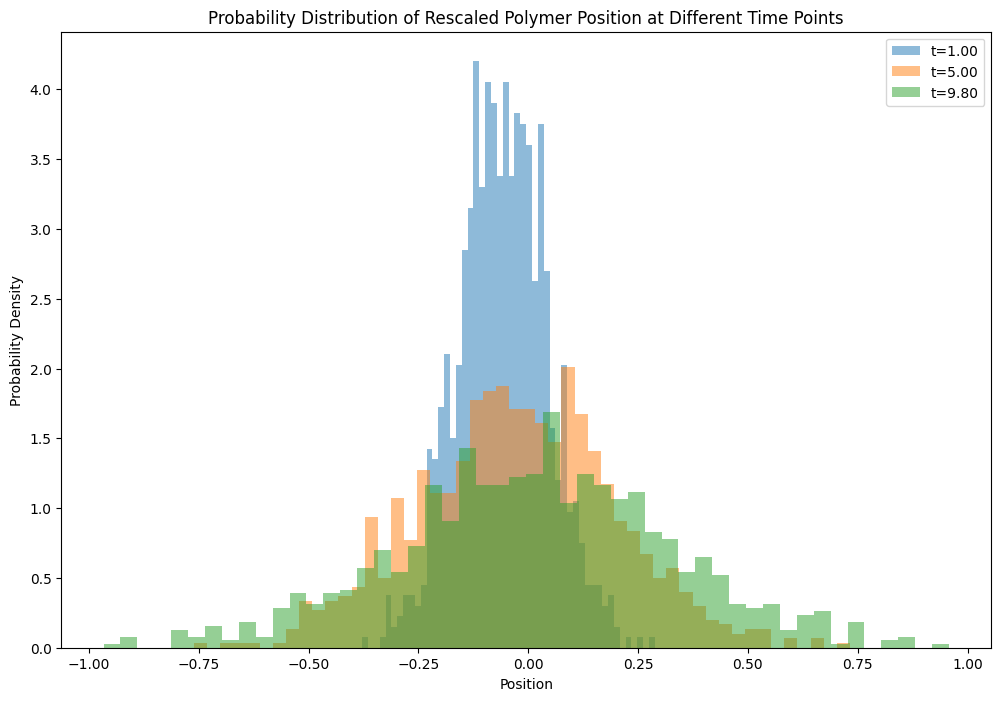

In [5]:
# Rescale data
X_rescaled = rescale_data(X)

# Ensure valid indices for time points
time_points = [int(num_steps * p) for p in [0.1, 0.5, 0.98]]

# Plot and check normalization
plt.figure(figsize=(12, 8))
for t in time_points:
    hist, bins, _ = plt.hist(X_rescaled[:, t], bins=50, alpha=0.5, density=True, label=f't={t*dt:.2f}')
    bin_width = bins[1] - bins[0]
    hist_integral = np.sum(hist * bin_width)
    print(f'Histogram integral at t={t*dt:.2f}: {hist_integral:.4f}')
plt.xlabel('Position')
plt.ylabel('Probability Density')
plt.legend()
plt.title('Probability Distribution of Rescaled Polymer Position at Different Time Points')
plt.show()

In [6]:
# Function to sample points from a specific time point
def sample_points_at_time(X, time_point, num_samples=100):
    indices = np.random.choice(X.shape[0], num_samples, replace=False)
    sampled_points = X[indices, time_point]
    return sampled_points

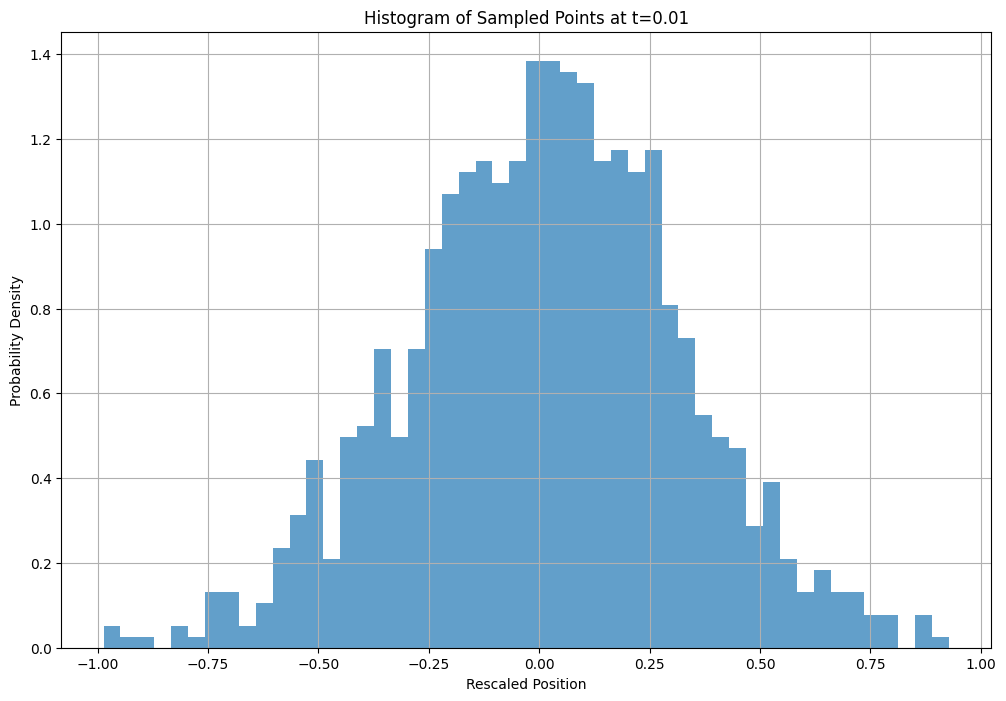

In [12]:
# Specify the time point for sampling (e.g., 0.5)
time_point_ratio = 0.96
time_index = int(num_steps * time_point_ratio)

# Sample points from the distribution at the specified time point
num_samples = 1000
sampled_points = sample_points_at_time(X_rescaled, time_index, num_samples)

# Plot the sampled points as a histogram
plt.figure(figsize=(12, 8))
plt.hist(sampled_points, bins=50, density=True, alpha=0.7)
plt.xlabel('Rescaled Position')
plt.ylabel('Probability Density')
plt.title(f'Histogram of Sampled Points at t={time_point_ratio*dt:.2f}')
plt.grid(True)
plt.show()